/var/folders/sy/n_c36kvx487143mhq4gvc7b40000gn/T/ipykernel_43217/4010019860.py:51: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  pro = pd.read_csv("/Volumes/data_files/UKB_data/processed_data/immune_pro.csv")


XGBoost AUC: 0.85
Random Forest AUC: 0.84
[LightGBM] [Warning] lambda_l1 is set=9.91370074517491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.91370074517491
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5320221329795254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320221329795254
[LightGBM] [Warning] bagging_fraction is set=0.8866412120575335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8866412120575335
[LightGBM] [Warning] lambda_l2 is set=6.307117883176452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.307117883176452
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=9.91370074517491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.91370074517491
[LightGBM] [Warning] bagging_freq is 

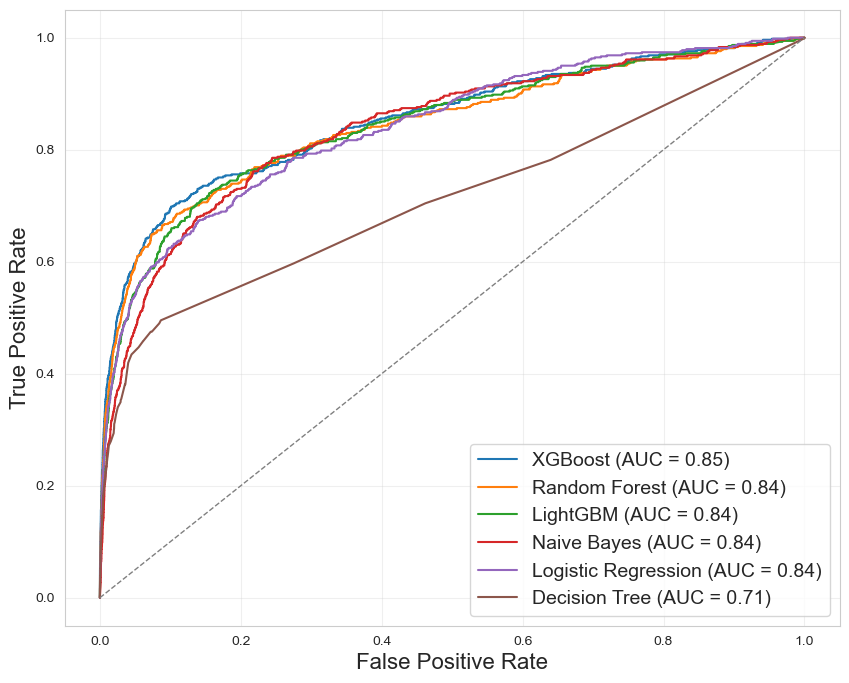

In [5]:
import os
import pandas as pd
import joblib
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=Warning)

def plot_multiple_roc_curves(models, model_names, pro_data, pro_labels, output_dir):

    disease = "SLE"
    y = pro_labels[disease]
    X = pro_data

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    plt.figure(figsize=(10, 8))
    for model_path, model_name in zip(models, model_names):

        model = joblib.load(model_path)

        y_pred_proba = cross_val_predict(model, X, y, cv=skf, method='predict_proba')[:, 1]

        roc_auc = roc_auc_score(y, y_pred_proba)
        print(f"{model_name} AUC: {roc_auc:.2f}")

        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
    plt.xlabel('False Positive Rate',fontsize=16)
    plt.ylabel('True Positive Rate',fontsize=16)
    # plt.title('ROC Curves for Multiple Models')
    plt.legend(loc="lower right",fontsize=14)
    plt.grid(alpha=0.3)

    # # 保存图像
    # if not os.path.exists(output_dir):
    #     os.makedirs(output_dir)

    output_path = os.path.join(output_dir, "multiple_roc_curves_2.pdf")
    # output_path = os.path.join(output_dir, "multiple_roc_curves_5.pdf")
    # output_path = os.path.join(output_dir, "multiple_roc_curves_5_10.pdf")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()

    # print(f"ROC curves saved to {output_path}")

# 示例使用
if __name__ == '__main__':
    # 加载数据
    pro = pd.read_csv("/Volumes/data_files/UKB_data/processed_data/immune_pro.csv")
    pro = pro.fillna(pro.median(numeric_only=True))

    # 提取特征和目标变量
    pro_data = pro[['trim21', 'il15', 'scarb2', 'lgals9', 'pdcd1', 'sod2', 'mepe', 'lag3', 'cxcl16', 'pomc', 'bst2']]
    pro_labels = pro[["SLE"]]
    
    # 5年内的
    pro = pro[((pro["fp-SLE"] > 0) & (pro["fp-SLE"] < 5)) | (pro["SLE"] == 0)]
    # 5年外
    # pro = pro[(pro["fp-SLE"] > 5)| (pro["SLE"] == 0)]
    # 定义模型路径和名称
    model_paths = [
        "/Volumes/data_files/UKB_data/immune_result/sle_models/xgboost/result2/SLE_best_xgboost_model.pkl",
        "/Volumes/data_files/UKB_data/immune_result/sle_models/random_forest/result2/SLE_best_rf_model.pkl",
        "/Volumes/data_files/UKB_data/immune_result/sle_models/lightgbm/result2/SLE_best_lightgbm_model.pkl",
        "/Volumes/data_files/UKB_data/immune_result/sle_models/naive_bayes/result2/SLE_best_nb_model.pkl",
        "/Volumes/data_files/UKB_data/immune_result/sle_models/logistic_regression/result2/SLE_best_lr_model.pkl",
        "/Volumes/data_files/UKB_data/immune_result/sle_models/decision_tree/result2/SLE_best_dt_model.pkl"
        
    ]
    # model_names = ["Logistic Regression", "XGBoost", "Random Forest", "LightGBM", "Naive Bayes", "Decision Tree"]
    model_names = [ "XGBoost", "Random Forest", "LightGBM", "Naive Bayes", "Logistic Regression", "Decision Tree"]

    # 绘制多个模型的 ROC 曲线
    plot_multiple_roc_curves(model_paths, model_names, pro_data, pro_labels, output_dir="/Volumes/data_files/UKB_data/immune_result/km_curves_auc")